# Réseaux de neurones


Dans ce tutoriel, nous allons explorer les réseaux de neurones. Le but est d'expliquer, dans les grandes lignes, le fonctionnement d'un réseau de neurones. De plus, ce tutoriel vous permettra d'explorer l'utilisation de PyTorch, ainsi que l'utilisation de PyTorch + Lightning.

**Quelques avertissements avant de commencer** J'ai masqué beaucoup de code dans Colab pour deux raisons : 1) C'est du code qui ne sert qu'à faire des beaux graphiques 2) C'est du code qui est la solution de l'exercice. Veuillez n'ouvrir les cellules qu'après avoir fini le tutoriel.

L'importation des librairies est relativement lent, donc exécutez tout de suite cette cellule. J'ai caché les sorties, si jamais vous avez un problème, enlevez `%%capture` puis regardez le message d'erreur.

Je ne garantis pas non plus que l'architecture du réseau de neurones ainsi que les hyperparamètres sont optimaux. Avec 10 époques, j'avais entre 80 et 90 % d'accuracy. Le seeding ne se fait pas correctement sur Colab, donc il est possible que les résultats varient.

Vérifiez bien que l'environnement de travail de Colab utilise un GPU. Ça va rendre l'entraînement des réseaux de neurones beaucoup plus rapide.

In [2]:
# @title Importations des librairies

!pip install lightning
!pip install "deeplake<4"
!pip install deeplake[audio]

import torch
from torch import nn
import torchaudio
import lightning as L
import matplotlib.pyplot as plt
from IPython.display import Audio
import numpy as np
import deeplake
import random
from torchmetrics.classification import MulticlassAccuracy
import seaborn as sn
import os

class ErreurDansLeLaboratoire(Exception):
  def __init__(self):
    super().__init__("Cette cellule contient une partie de la solution de ce tutoriel. Veuillez ne l'ouvrir que quand vous avez fini.")


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 640.2/640.2 kB 313.2 kB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
INFO: pip is looking at multiple versions of s3transfer to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 312.6 kB/s eta 0:00:00a 0:00:01
Using cached annotated_types-0.7.0-py3-none-any.whl (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 334.1 kB/s eta 0:00:0000:0100:02
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Created wheel for deeplake: filename=deeplake-3.9.44-py3-none-any.whl

ModuleNotFoundError: No module named 'torchaudio'

# Créer le jeu de données

Dans le cadre de ce tutoriel, nous allons entraîner un réseau de neurones convolutif (CNN) sur le jeu de données Free Spoken Digit Dataset (FSDD), qui est l'équivalent de MNIST mais avec de l'audio.

Commençons par importer le jeu de données. On sépare les données en trois sections : entraînement, validation et test.

Vous pouvez visualiser les données. Les données ont été enregistrées par 6 personnes, qui ont répétés chaque chiffre de 0 à 9 50 fois.

In [ ]:
# @title Importer les données
from lightning.pytorch import seed_everything

seed_everything(42, workers=True)

ds = deeplake.load("hub://activeloop/spoken_mnist")

ds.visualize()
N_train = 2000
N_val = 500

# shuffle the dataset
lst_shfl = list(range(len(ds)))
random.shuffle(lst_shfl)
ds = ds[lst_shfl]

# split the dataset
ds_train = ds[:N_train]
ds_val = ds[N_train:N_train+N_val]
ds_test = ds[N_train+N_val:]

Pour entraîner le réseau de neurones, nous aurons besoin d'organiser les données dans un jeu de données qui pourra être utilisé par les dataloaders de PyTorch. Les détails ne sont pas importants pour l'instant, vous pouvez revenir plus tard.

De plus, j'ai décidé de traiter des batchs de données, au lieu d'entraîner le modèle avec une donnée à la fois. Comme les séquences sont de longueurs variables, j'ai décidé d'ajouter du "padding" par batch. La fonction `collate_fn` va être appelée par le dataloader pour rajouter des zéros à la fin des séquences trop courtes.

C'est un choix de design évidemment, mais c'est celui que j'ai choisi.

In [ ]:
# @title Définition du jeu de données
# Inspiré de https://docs.deeplake.ai/4.1/guide/deep-learning/async-data-loader/
class AudioDataset(torch.utils.data.Dataset):
    def __init__(self, deeplake_ds):
        self.ds = deeplake_ds

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, item):
        audio =  self.ds[item]["audio"].data(aslist=True)['value']
        target = self.ds[item]["labels"].data()['value']

        return audio, target


def collate_fn(data):
  """
  Avant de soumettre la batch de données au réseau de neurones, on peut vouloir
  traiter les données. La fonction collate_fn va traiter les données pour qu'elles
  puissent être utilisées correctement.

  Dans notre cas, puisque les données ne sont pas toutes de la même longueur, on
  va pad chaque batch pour que toutes les données soient de la même longueur.

  """
  audio = [torch.tensor(datapoint[0]).float() for datapoint in data]
  targets = torch.tensor([datapoint[1][0] for datapoint in data]).to(torch.int64)

  features = torch.nn.utils.rnn.pad_sequence(audio, batch_first=False).transpose(2,1).transpose(0,2)
  return features, targets


Nous allons maintenant définir nos dataloaders. Les dataloaders font plusieurs choses en même temps. Premièrement, ils vont prendre les données et vont créer des batchs, qui seront fournies au réseau de neurone à entraîner. De plus, durant l'entraînement, les données seront permutées pour éviter d'avoir des batchs identiques à chaque étape. Finalement, `collate_fn` est appliquée sur chaque batch.

Vous pouvez vous amuser à modifier la batch_size et le nombre d'époques d'entraînement. Une batch size plus grande vient généralement avec une meilleure utilisation du GPU, mais ne veut pas nécessairement dire que les performances vont être mieux. Plus d'époques veut dire que le modèle va probablement être mieux entraînés et va donner de meilleures performances.

In [ ]:
# @title Définir les dataloaders
batch_size = 32
max_epochs = 10

train_loader = torch.utils.data.DataLoader(AudioDataset(ds_train),
                            batch_size=batch_size,
                            shuffle=True,
                            collate_fn=collate_fn)

validation_loader = torch.utils.data.DataLoader(AudioDataset(ds_val),
                            batch_size=batch_size,
                            shuffle=False,
                            collate_fn=collate_fn)

test_loader = torch.utils.data.DataLoader(AudioDataset(ds_test),
                            batch_size=batch_size,
                            shuffle=False,
                            collate_fn=collate_fn)

# Ce dataloader n'est pas toujours nécessaire, mais je l'ai rajouté pour que
# l'erreur en test soit déterministe
testing_train_loader = torch.utils.data.DataLoader(AudioDataset(ds_train),
                            batch_size=batch_size,
                            shuffle=False,
                            collate_fn=collate_fn)

# Entraînement d'un réseau de neurones

Dans cette section, nous allons entraîner un réseau de neurones avec PyTorch + Lightning.

PyTorch est une librairie qui définit toutes les fonctions nécessaires pour entraîner un réseau de neurones. On va donc pouvoir définir le réseau de neurones et l'entraîner.

Lightning a été introduit pour éviter aux utilisateurs de réécrire à chaque fois le même "boiler plate code". C'est du code qui doit être défini à chaque fois et qui n'est jamais vraiment modifié. Utiliser Lightning permet ainsi de sauver beaucoup de temps passé à réécrire toutes les fonctions nécessaires à entraîner un réseau de neurones.

Nous allons maintenant définir le réseau de neurones. Puisqu'on utilise Lightning, on doit définir deux classes : le réseau de neurones et sa classe d'entraînement. Le réseau de neurones est initialisé exactement comme on l'aurait fait avec du pur PyTorch. La deuxième classe va être utilisée lorsqu'on veut entraîner le modèle, donc on va automatiquement définir l'optimiseur et le comportement en entraînement, validation et test.

On va maintenant instancier les classes. Le réseau de neurones est imprimé, prenez le temps d'essayer de comprendre chaque couche.

In [ ]:
# @title Définition du réseau de neurones
class AudioNet(nn.Module):
    def __init__(self, n_classes=10, dropout_probability=0.2):
        super().__init__()
        self.n_classes = n_classes
        self.dropout_probability = dropout_probability
        self.cnn_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Dropout(self.dropout_probability),
            nn.BatchNorm1d(32),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Dropout(self.dropout_probability),
            nn.BatchNorm1d(64),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=8,stride=4),
            nn.ReLU(),
            nn.Dropout(self.dropout_probability),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(self.dropout_probability),
            nn.Linear(128, self.n_classes),
        )

    def forward(self, input):
        out = self.cnn_layers(input)
        return self.linear_layers(out.mean(-1))

class ClassificationModel(L.LightningModule):
    def __init__(self, model, optimizer="Adam", lr=1e-3):
        super().__init__()
        self.optimizer = optimizer
        self.lr = lr
        self.model = model
        self.loss = torch.nn.CrossEntropyLoss()
        self.metric = MulticlassAccuracy(num_classes=self.model.n_classes).to(self.device)
        self.conf_mat = torch.zeros(self.model.n_classes, self.model.n_classes)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        train_acc = self.metric(torch.argmax(y_hat, dim=1), y)
        self.log("train_acc", train_acc, prog_bar=True)

        loss = self.loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        pred = y_hat.argmax(-1)
        for i in range(x.shape[0]):
          self.conf_mat[y.cpu()[i].item(), pred.cpu()[i].item()] += 1
        return None

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        validation_acc = self.metric(torch.argmax(y_hat, dim=1), y)
        self.log("validation_acc", validation_acc)
        return torch.nn.CrossEntropyLoss(reduction='sum')(y_hat, y)


    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        test_acc = self.metric(torch.argmax(y_hat, dim=1), y)
        self.log("test_acc", test_acc)

    def configure_optimizers(self):
      if self.optimizer == "Adam":
        return torch.optim.Adam(self.parameters(), lr=self.lr)
      elif self.optimizer == "SGD":
        return torch.optim.SGD(self.parameters(), lr=self.lr)


first_model = AudioNet(10, 0.2)
first_model

**Conv1d**

L'opération de convolution avait été abordé dans un laboratoire précédent. Dans une couche de convolution, on applique un filtre (qui contient des paramètres entraînables) sur un signal.

Dans l'image suivante, on a un filtre qui contient $[1,0,1]$. Appliqué sur le vecteur $[1,0,0]$, on a :

$$ 1*1 + 0 * 0 + 0 * 1 = 1$$

Plus la taille du noyau est grande (paramètre kernel_size de Conv1d), plus on va agréger le contexte autour d'un seul point. On utilise donc l'information des données avant et après un certain point pour obtenir la prochaine représentation des données.

De plus, on va généralement faire cette opération pour un grand nombre de filtres. Dans la première couche d'AudioNet, on applique 32 filtres sur le signal d'entrée.

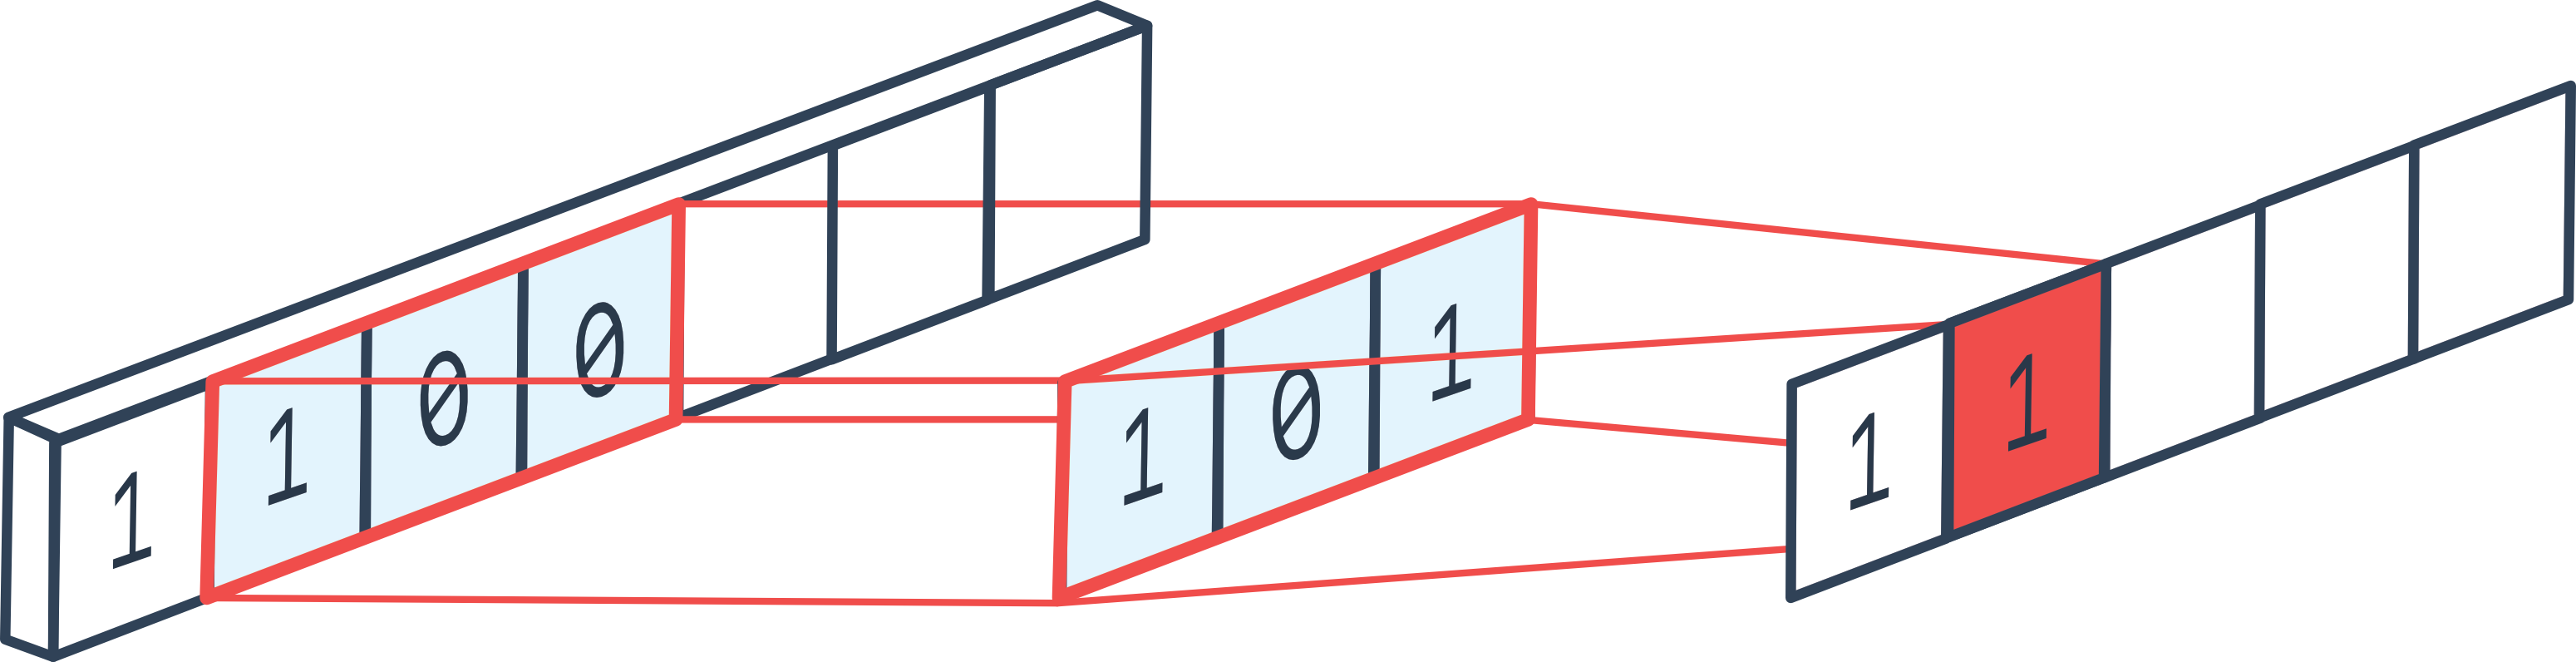

[source](https://stackoverflow.com/questions/65006011/size-of-output-of-a-conv1d-layer-in-keras)

**ReLU**

La grande force des réseaux de neurones est l'application de non-linéarités entre les différentes couches. En effet, si on multipliait toutes les matrices d'un réseau de neurone sans ajouter de la non-linéarité, le réseau de neurones est équivalent à une régression linéaire.

Selon moi, la fonction d'activation la plus connue et la plus utilisée est probablement la ReLU (*rectified linear unit*) :
$$ReLU(x) = \max(0, x).$$


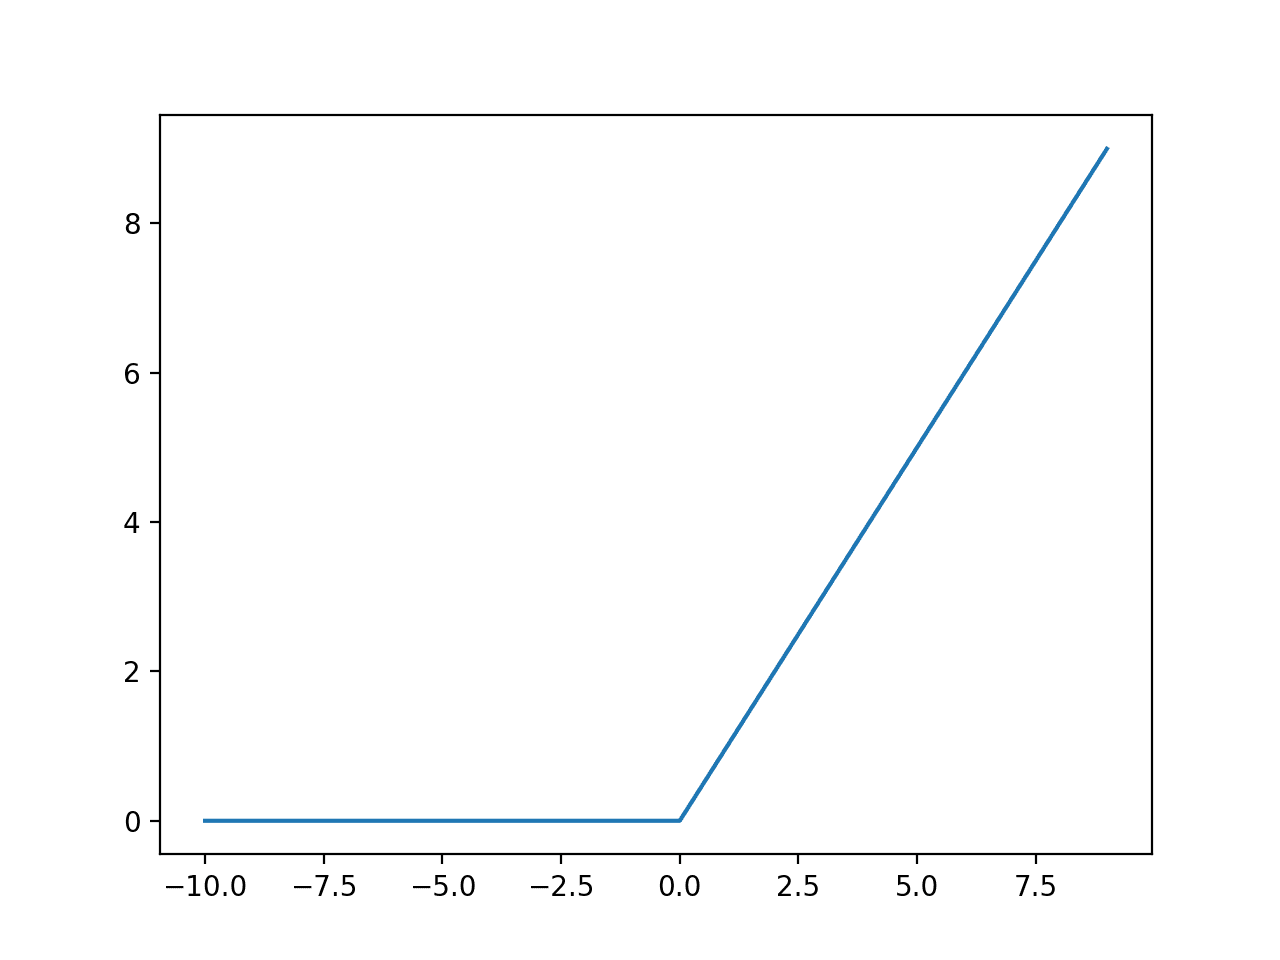
[source](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)

Le dropout est une méthode de régularisation qui va supprimer des neurones durant l'entraînement de manière aléatoire. À chaque époque, les neurones supprimés vont être différents.

Entraîner un modèle avec du dropout force le modèle à utiliser tous les neurones correctement. Si le modèle est capable de s'entraîner même en perdant des neurones à chaque itération, il devrait bien fonctionner après l'entraînement.

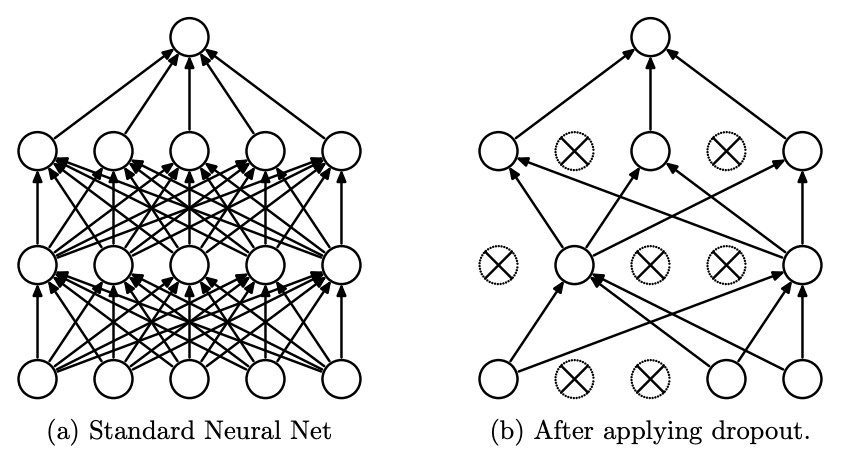

[source](https://jmlr.org/papers/v15/srivastava14a.html)

Page PyTorch des différents layers utilisés :

[Conv1d](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html)

[ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)

[Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

[BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)

[MaxPool1d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html)

[Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)


L'entraînement de modèle se fait en deux phases:

1.   Forward propagation
2.   Backward propagation


**Forward propagation**

La "forward propagation" est l'étape d'inférence du modèle. Le modèle prend un signal en entrée, puis multiplie le signal avec la première couche. Ensuite, une fonction d'activation est appliquée. On continue jusqu'à la dernière couche.

Pour un réseau de neurones linéaire (MLP) à trois couches, on a :

$$ MLP(x) = W_3\sigma(W_2\sigma(W_1 x + b_1) + b_2) + b_3$$

avec $W_1, W_2, W_3$ les poids des couches linéaires, $b_1, b_2, b_3$ le biais des couches et $\sigma$ une fonction d'activation.

On applique parfois un [SoftMax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) à la dernière couche pour obtenir la probabilité d'appartenance à différentes classes.

In [ ]:
# @title Exemple de propagation de donnée d'un modèle non-entraîné
fig, axs = plt.subplots(2, 4, figsize=(20,10))

first_model.eval()
index = 0
axs[0,0].plot(ds_train[index]['audio'])
axs[0,0].set_title("Entrée du modèle")

with torch.no_grad():
  out_cnn = first_model.cnn_layers[0](torch.tensor(ds_train[index]["audio"].data()['value']).transpose(1,0).float().unsqueeze(0))
axs[0,1].plot(out_cnn.mean(1).reshape(-1,))
axs[0,1].set_title("Moyenne (sur les filtres) du signal\n après 1 couche de convolution")


with torch.no_grad():
  out_cnn = first_model.cnn_layers[0:5](torch.tensor(ds_train[index]["audio"].data()['value']).transpose(1,0).float().unsqueeze(0))
axs[0,2].plot(out_cnn.mean(1).reshape(-1,))
axs[0,2].set_title("Moyenne (sur les filtres) du signal\n après 2 couche de convolution")


with torch.no_grad():
  out_cnn = first_model.cnn_layers[0:9](torch.tensor(ds_train[index]["audio"].data()['value']).transpose(1,0).float().unsqueeze(0))
axs[0,3].plot(out_cnn.mean(1).reshape(-1,))
axs[0,3].set_title("Moyenne (sur les filtres) du signal\n après 3 couche de convolution")

with torch.no_grad():
  out_cnn = first_model.cnn_layers(torch.tensor(ds_train[index]["audio"].data()['value']).transpose(1,0).float().unsqueeze(0))
axs[1,0].plot(out_cnn.mean(-1).reshape(-1,))
axs[1,0].set_title("Moyenne (sur le temps) du signal\n après le maxpooling")

with torch.no_grad():
  out = first_model.linear_layers[0](out_cnn.mean(-1))
axs[1,1].plot(out.reshape(-1,))
axs[1,1].set_title("Sortie après une \ncouche linéaire")

with torch.no_grad():
  out = nn.Softmax(dim=1)(first_model(torch.tensor(ds_train[index]["audio"].data()['value']).transpose(1,0).float().unsqueeze(0)))
axs[1,2].scatter(np.arange(10), out.reshape(-1,))
axs[1,2].set_ylim(-0.05,1)
axs[1,2].set_title("Classification du modèle")

fig.delaxes(axs[1,3])

fig.show()

print(f"La donnée à classifier est un {ds_train[index]['labels'].data()['value'].item()}. La sortie du réseau de neurones est un {out.argmax(-1).item()}.")

**Backward propagation**

L'étape de la backprop est automatiquement gérée par PyTorch, mais il est important de comprendre comment cela fonctionne, pour pouvoir mieux comprendre comment les réseaux de neurones s'entraînent.

Pour ce faire, on calcule la dérivée de la perte en fonction de la valeur prédite par chaque neurone de sortie du modèle. Ensuite, on va propager le gradient de la dernière couche à la première couche, mettant ainsi à jour chaque neurone.

On fait donc de la descente de gradient stochastique (SGD) sur chaque poids du modèle, le mettant à jour jusqu'à ce que le modèle ne fasse plus d'erreur ou qu'on soit satisfait du taux d'erreur.


Pour en apprendre davantage sur la backprop, je recommande **fortement** la playliste de 3Blue1Brown : https://youtu.be/aircAruvnKk?si=m4XFzh893N6REXiZ

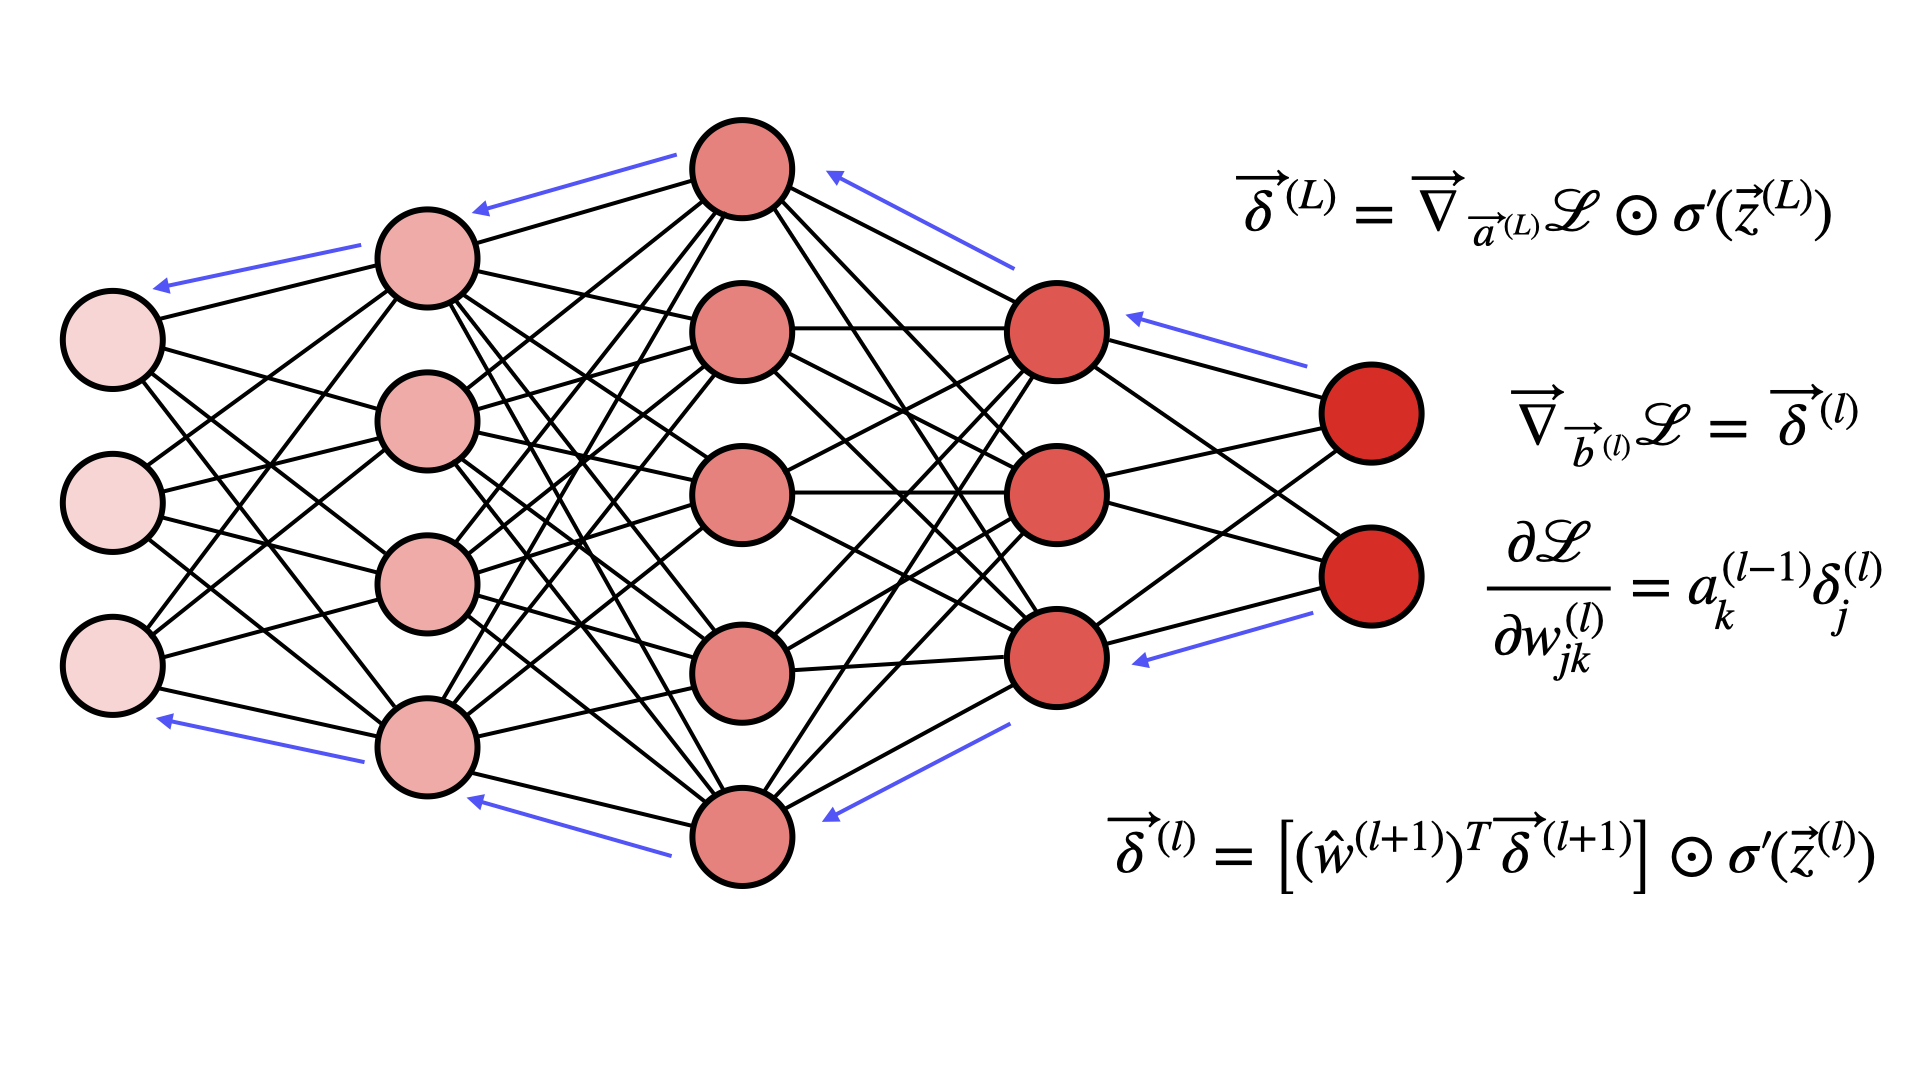

[Source](https://devforum.roblox.com/t/understanding-neural-network-backpropagation-learning-algorithm/1838115)

Entraînons maintenant le modèle. Pour ce faire, on initialise le réseau de neurones, la classe d'entraînement et l'entraîneur. La classe `Trainer` va automatiquement gérer l'optimisation de notre modèle.

Normalement, on serait fortement avisé de passer `val_dataloaders=validation_loader`. Toutefois, j'ai ignoré ce paramètre pour que l'entraînement soit exactement équivalent à celui de l'exercice plus bas.

Vous pouvez jouer avec le dropout, l'optimiseur et le learning rate, pour voir la différence que cela fait durant l'entraînement. La classe `ClassificationModel` supporte `SGD`et `Adam` comme optimiseur.

In [ ]:
# Initialiser le réseau de neurones
model = AudioNet(dropout_probability=0.2)

# Intialiser le modèle à entraîner
lightning_model = ClassificationModel(model, optimizer="Adam", lr=0.005)

# Initialiser l'entraîneur
trainer = L.Trainer(max_epochs=max_epochs, log_every_n_steps=10, inference_mode=False)

# Entraîner le modèle
trainer.fit(model=lightning_model, train_dataloaders=train_loader)

On calcule maintenant l'accuracy sur les données d'entraînement, de validation et de test.

In [ ]:
# On calcule maintenant l'erreur sur le jeu de données en entraînement, en validation et en test

print("Calcul de l'erreur sur le jeu de données d'entraînement")
trainer.validate(model=lightning_model, dataloaders=testing_train_loader)

print("Calcul de l'erreur sur le jeu de données de validation")
trainer.validate(model=lightning_model, dataloaders=validation_loader)

print("Calcul de l'erreur sur le jeu de données de test")
trainer.test(model=lightning_model, dataloaders=test_loader)
print()

Finalement, on peut calculer les matrices de confusions sur les trois ensembles de données. La matrice de confusion nous permet de savoir si les données sont bien classifiées ou non, et comment elles sont classifiées quand elles ne sont pas classifiées correctement.

In [ ]:
# @title Calcul des matrices de confusion
fig, axs = plt.subplots(1, 3, figsize=(20,5))

trainer.predict(model=lightning_model, dataloaders=testing_train_loader, return_predictions=False)
sn.heatmap(lightning_model.conf_mat.to(int), annot=True, fmt="d", ax=axs[0])
axs[0].set_title("Matrice de confusion du jeu de donnés d'entraînement")

trainer.predict(model=lightning_model, dataloaders=validation_loader, return_predictions=False)
sn.heatmap(lightning_model.conf_mat.to(int), annot=True, fmt="d", ax=axs[1])
axs[1].set_title("Matrice de confusion du jeu de donnés de validation")

trainer.predict(model=lightning_model, dataloaders=test_loader, return_predictions=False)
sn.heatmap(lightning_model.conf_mat.to(int), annot=True, fmt="d", ax=axs[2])
axs[2].set_title("Matrice de confusion du jeu de donnés de test")

fig.show()

On reprend maintenant notre exemple de propagation dans le modèle. On ne peut pas vraiment déduire quoique ce soit de ces graphiques, puisque c'est la moyenne sur beaucoup de filtres, mais c'est tout de même intéressant à regarder.

In [ ]:
# @title Exemple de propagation de donnée d'un modèle entraîné
fig, axs = plt.subplots(2, 4, figsize=(20,10))

model.eval()
index = 0
axs[0,0].plot(ds_train[index]['audio'])
axs[0,0].set_title("Entrée du modèle")

with torch.no_grad():
  out_cnn = model.cnn_layers[0](torch.tensor(ds_train[index]["audio"].data()['value']).transpose(1,0).float().unsqueeze(0))
axs[0,1].plot(out_cnn.mean(1).reshape(-1,))
axs[0,1].set_title("Moyenne (sur les filtres) du signal\n après 1 couche de convolution")


with torch.no_grad():
  out_cnn = model.cnn_layers[0:5](torch.tensor(ds_train[index]["audio"].data()['value']).transpose(1,0).float().unsqueeze(0))
axs[0,2].plot(out_cnn.mean(1).reshape(-1,))
axs[0,2].set_title("Moyenne (sur les filtres) du signal\n après 2 couche de convolution")


with torch.no_grad():
  out_cnn = model.cnn_layers[0:9](torch.tensor(ds_train[index]["audio"].data()['value']).transpose(1,0).float().unsqueeze(0))
axs[0,3].plot(out_cnn.mean(1).reshape(-1,))
axs[0,3].set_title("Moyenne (sur les filtres) du signal\n après 3 couche de convolution")

with torch.no_grad():
  out_cnn = model.cnn_layers(torch.tensor(ds_train[index]["audio"].data()['value']).transpose(1,0).float().unsqueeze(0))
axs[1,0].plot(out_cnn.mean(-1).reshape(-1,))
axs[1,0].set_title("Moyenne (sur le temps) du signal\n après le maxpooling")

with torch.no_grad():
  out = model.linear_layers[0](out_cnn.mean(-1))
axs[1,1].plot(out.reshape(-1,))
axs[1,1].set_title("Sortie après une \ncouche linéaire")

with torch.no_grad():
  out = nn.Softmax(dim=1)(model(torch.tensor(ds_train[index]["audio"].data()['value']).transpose(1,0).float().unsqueeze(0)))
axs[1,2].scatter(np.arange(10), out.reshape(-1,))
axs[1,2].set_title("Classification du modèle")
axs[1,2].set_ylim(-0.05,1)

fig.delaxes(axs[1,3])

fig.show()

print(f"La donnée à classifier est un {ds_train[index]['labels'].data()['value'].item()}. La sortie du réseau de neurones est un {out.argmax(-1).item()}.")

# Exercice

Le but de cet exercice est de vous montrer comment entraîner un réseau de neurones sans utiliser Lightning. On utilise ainsi du pur PyTorch pour faire notre entraînement.

Après chaque exercice, j'ai caché la solution. Essayez de faire l'exercice sans regarder la solution. Aussi, c'est évident que ChatGPT (ou tout autre LLM) connaît les réponses, parce que c'est du code "boiler plate" super simple. C'est plus intéressant si vous l'essayez par vous-même.



Le premier exercice est de compléter la classe ManualAudioNet. J'ai défini tous les layers, mais vous devez implémenter la "forward propagation". J'ai donné un exemple avec la première couche de convolution.

In [ ]:
class ManualAudioNet(nn.Module):
    def __init__(self, n_classes=10, dropout_probability=0.2):
        super().__init__()
        self.n_classes = n_classes
        self.dropout_probability = dropout_probability
        # repeating layers
        self.drop_layer =  nn.Dropout(self.dropout_probability)
        self.relu = nn.ReLU()

        # conv layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=8, stride=4)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=8,stride=4)
        self.bn3 = nn.BatchNorm1d(128)
        self.maxpool = nn.MaxPool1d(5)

        # linear layers
        self.lin1 = nn.Linear(128, 128)
        self.lin2 = nn.Linear(128, self.n_classes)

    def forward(self, input):
        # J'ai mis juste le premier layer, vous devez rajouter le reste

        # first layer : conv1d + relu + dropout + batch_norm
        out = self.conv1(input)
        # second layer : conv1d + relu + dropout + batch_norm
        out =
        # third layer : conv1d + relu + dropout + batch_norm
        out =
        # fourth layer : maxpool + taking the mean over the last dimension
        out = self.maxpool(out).mean(-1)

        # fifth layer : linear + relu + dropout
        out =
        # sixth layer : linear + return the output
        out =

        return out

In [ ]:
# @title Test de la sortie du modèle
test_model = ManualAudioNet()
test_model.eval()

with torch.no_grad():
    out = test_model(torch.tensor(ds_train[1]["audio"].data()['value']).transpose(1,0).float().unsqueeze(0))
assert out.shape == torch.Size([1, 10]), print(f"La sortie est de taille {out.shape}, alors qu'elle devrait être de taille {torch.Size([1, 10])}")
print("Test réussi!")

In [ ]:
# @title Solution à l'exercice : Ne pas ouvrir
raise ErreurDansLeLaboratoire




class ManualAudioNet(nn.Module):
    def __init__(self, n_classes=10, dropout_probability=0.2):
        super().__init__()
        self.n_classes = n_classes
        self.dropout_probability = dropout_probability
        # repeating layers
        self.drop_layer =  nn.Dropout(self.dropout_probability)
        self.relu = nn.ReLU()

        # conv layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=8, stride=4)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=8,stride=4)
        self.bn3 = nn.BatchNorm1d(128)
        self.maxpool = nn.MaxPool1d(5)

        # linear layers
        self.lin1 = nn.Linear(128, 128)
        self.lin2 = nn.Linear(128, self.n_classes)

    def forward(self, input):
        # first layer : conv1d + relu + dropout + batch_norm
        out = self.bn1(self.drop_layer(self.relu(self.conv1(input))))
        # second layer : conv1d + relu + dropout + batch_norm
        out = self.bn2(self.drop_layer(self.relu(self.conv2(out))))
        # third layer : conv1d + relu + dropout + batch_norm
        out = self.bn3(self.drop_layer(self.relu(self.conv3(out))))
        # fourth layer : maxpool + taking the mean over the last dimension
        out = self.maxpool(out).mean(-1)

        # fifth layer : linear + relu + dropout
        out = self.drop_layer(self.relu(self.lin1(out)))
        # sixth layer : linear + return the output
        out = self.lin2(out)
        return out

Maintenant que le modèle est implémenté, on doit vérifier s'il est possible de trouver un GPU au lieu d'utiliser un CPU.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

On définit le modèle, la perte d'entraînement et notre optimiseur. J'ai décidé d'utiliser [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html), car c'est un optimiseur bien connu, mais on aurait pu utiliser SGD ou autre.

La perte que l'on utilise est la Cross Entropy Loss :

$$\ell(x,y) = -\log \frac{\exp\big(MLP(x)_{y}\big)}{\sum_{c=1}^C \exp\big(MLP(x)_{c}\big)} $$

Avec $C$ le nombre de classes et $MLP(x)_c$ la prédiction pour la $c$-ième classe.

In [ ]:
# on crée le modèle puis on le met sur le gpu
model = ManualAudioNet(n_classes=10, dropout_probability=0.2).to(device)

# set the loss function
criterion = nn.CrossEntropyLoss()

# set the optimizer
# Vous pouvez jouer avec le learning rate, j'ai trouvé que 0.005 fonctionnait plutôt bien
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

Vous devez maintenant implémenter l'entraînement du modèle. Les instructions sont mises dans le code, vous devez simplement finir chaque ligne.



In [ ]:
for epoch in range(max_epochs):

    running_loss = 0.0
    for batch in train_loader:

        inputs, targets = batch

        # Envoyer les données sur le GPU
        inputs =
        targets =

        # zero the parameter gradients
        optimizer

        # forward du modèle
        outputs =

        # calculer la perte
        loss =

        # calculer les gradients grâce à la backprop
        loss

        # Faire la mise à jour
        optimizer

        # print statistics
        running_loss += loss.item()
    print(f"epoch : {epoch+1} loss : {running_loss/len(ds_train):.5f}")

In [ ]:
# @title Solution à l'exercice : Ne pas ouvrir
raise ErreurDansLeLaboratoire




for epoch in range(max_epochs):  # loop over the dataset multiple times (you might need more than 10 epochs)

    running_loss = 0.0
    for batch in train_loader:

        inputs, targets = batch

        inputs = inputs.to(device)
        targets = targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print(f"epoch : {epoch+1} loss : {running_loss/len(ds_train):.5f}")

Finalement, on va tester le modèle sur les données d'entraînement. La majorité du code est pareil, mais cette fois ci on va calculer l'accuracy au lieu de la cross entropy.

La formule de l'accuracy est la suivante :

$$Acc = \frac{1}{n}\sum_{i=1}^n \begin{cases} 1 & \text{si } \widehat{y}_i = y_i \\ 0 & \text{si } \widehat{y}_i \neq y_i\end{cases} $$

pour un jeu de données $S = \{(x_i, y_i)\}_{i=1}^n$ et $\widehat{y}_i$ la classe prédite par $MLP(x_i)$.


Puisqu'on veut calculer l'accuracy sur le jeu de données et non sur chaque batch, calculez simplement le nombre de données bien prédites ($n \cdot Acc$) et le code va automatique diviser par la taille du jeu de données.

In [ ]:
# mettre le modèle en mode d'évaluation
# La batch norm et le dropout ne fonctionne pas pareil en entraînement et en évaluation
# Vous pouvez tester la différence en commentant la ligne suivante
model.eval()

acc = 0

# On ne veut pas calculer les gradients, ils ne nous serviront pas.
with torch.no_grad():
  for sample in test_loader:

    inputs, targets = sample

    # Envoyer les données sur le GPU
    inputs =
    targets =

    # forward du modèle
    outputs =

    # Trouver la classe prédite par le modèle
    pred = outputs.argmax(-1)

    # Calculer le nombre de données prédites correctement.
    acc_batch =

    acc += acc_batch

acc = acc / len(ds_test)
print(f"L'accuracy sur le jeu de données de test est de {100*acc:.2f} %")

In [ ]:
# @title Solution à l'exercice : Ne pas ouvrir

raise ErreurDansLeLaboratoire



model.eval()

acc = 0
with torch.no_grad():
  for sample in test_loader:

    inputs, targets = sample

    inputs = inputs.to(device)
    targets = targets.to(device)

    outputs = model(inputs)
    pred = outputs.argmax(-1)
    acc_batch = (targets == pred).sum().item()
    acc += acc_batch

acc = acc / len(ds_test)
print(f"L'accuracy sur le jeu de données de test est de {100*acc:.2f} %")

In [ ]:
# @title Calcul des matrices de confusion : Ne pas ouvrir avant d'avoir fait l'exercice précédent

fig, axs = plt.subplots(1, 3, figsize=(20,5))

# mettre le modèle en mode d'évaluation
model.eval()

conf_mat = torch.zeros(10, 10)

acc = 0
with torch.no_grad():
  for sample in testing_train_loader:

    inputs, targets = sample

    inputs = inputs.to(device)
    targets = targets.to(device)

    outputs = model(inputs)
    pred = outputs.argmax(-1)
    acc += (targets == pred).sum().item()

    for i in range(inputs.shape[0]):
      conf_mat[targets[i], pred[i]] += 1

acc = acc / len(ds_train)
sn.heatmap(conf_mat.to(int), annot=True, fmt="d", ax=axs[0])
axs[0].set_title("Matrice de confusion du jeu de donnés d'entraînement")
print(f"L'accuracy sur le jeu de données d'entraînement est de {100*acc:.2f} %")

conf_mat = torch.zeros(10, 10)

acc = 0
with torch.no_grad():
  for sample in validation_loader:

    inputs, targets = sample

    inputs = inputs.to(device)
    targets = targets.to(device)

    outputs = model(inputs)
    pred = outputs.argmax(-1)
    acc += (targets == pred).sum().item()

    for i in range(inputs.shape[0]):
      conf_mat[targets[i], pred[i]] += 1

acc = acc / len(ds_val)
sn.heatmap(conf_mat.to(int), annot=True, fmt="d", ax=axs[1])
axs[1].set_title("Matrice de confusion du jeu de donnés de validation")
print(f"L'accuracy sur le jeu de données de validation est de {100*acc:.2f} %")

conf_mat = torch.zeros(10, 10)

acc = 0
with torch.no_grad():
  for sample in test_loader:

    inputs, targets = sample

    inputs = inputs.to(device)
    targets = targets.to(device)

    outputs = model(inputs)
    pred = outputs.argmax(-1)
    acc += (targets == pred).sum().item()

    for i in range(inputs.shape[0]):
      conf_mat[targets[i], pred[i]] += 1

acc = acc / len(ds_test)
sn.heatmap(conf_mat.to(int), annot=True, fmt="d", ax=axs[2])
axs[2].set_title("Matrice de confusion du jeu de donnés de test")
print(f"L'accuracy sur le jeu de données de test est de {100*acc:.2f} %")

fig.show()